C:\Users\ARGHYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


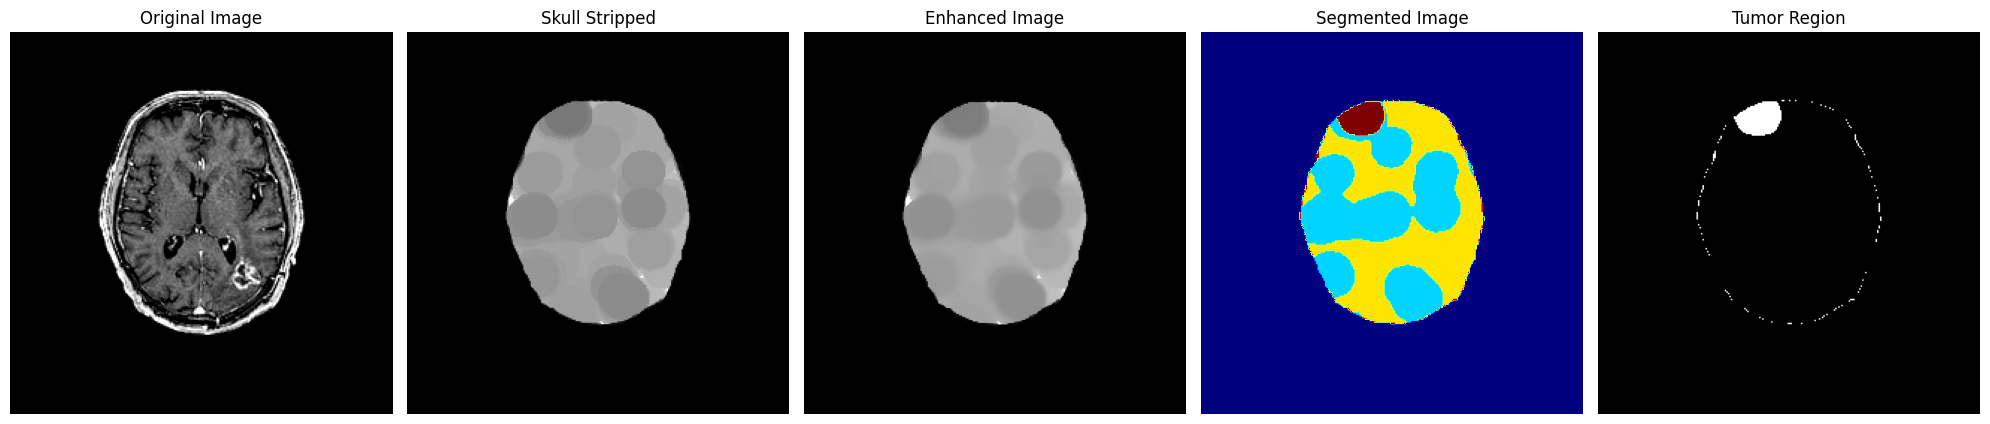

In [1]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load the Image
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img

# Step 2: Skull Stripping (Morphological Operations)
def skull_stripping(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    stripped = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)  # Fill gaps
    stripped = cv2.morphologyEx(stripped, cv2.MORPH_ERODE, kernel)  # Remove outer skull
    return stripped

# Step 3: Image Enhancement with Perona-Malik Anisotropic Diffusion
def anisotropic_diffusion(img, iterations=10, kappa=20, gamma=0.1):
    img = img.astype(np.float64)  # Convert to float64 for calculations
    for i in range(iterations):
        nabla_north = np.roll(img, -1, axis=0) - img
        nabla_south = np.roll(img, 1, axis=0) - img
        nabla_east = np.roll(img, -1, axis=1) - img
        nabla_west = np.roll(img, 1, axis=1) - img

        c_north = np.exp(-(nabla_north / kappa) ** 2)
        c_south = np.exp(-(nabla_south / kappa) ** 2)
        c_east = np.exp(-(nabla_east / kappa) ** 2)
        c_west = np.exp(-(nabla_west / kappa) ** 2)

        img += gamma * (
            c_north * nabla_north + c_south * nabla_south + c_east * nabla_east + c_west * nabla_west
        )
    return img.astype(np.uint8)  # Convert back to uint8

# Step 4: Segmentation using K-Means Clustering
def kmeans_segmentation(img, n_clusters=4):
    reshaped_img = img.reshape((-1, 1))  # Flatten the image
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(reshaped_img)
    segmented = kmeans.labels_.reshape(img.shape)
    return segmented

# Step 5: Tumor Extraction
def extract_tumor(segmented_img, cluster_idx):
    tumor_region = (segmented_img == cluster_idx).astype(np.uint8)
    return tumor_region

# Step 6: Visualization
def visualize_results(original, skull_stripped, enhanced, segmented, tumor):
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original Image")
    axs[1].imshow(skull_stripped, cmap='gray')
    axs[1].set_title("Skull Stripped")
    axs[2].imshow(enhanced, cmap='gray')
    axs[2].set_title("Enhanced Image")
    axs[3].imshow(segmented, cmap='jet')
    axs[3].set_title("Segmented Image")
    axs[4].imshow(tumor, cmap='gray')
    axs[4].set_title("Tumor Region")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Main Function
# def main():
    # Load Image
image_path = "060.png"  # Replace with the path to your image
original_img = load_image(image_path)

# Skull Stripping
skull_stripped_img = skull_stripping(original_img)

# Image Enhancement
enhanced_img = anisotropic_diffusion(skull_stripped_img)

# Segmentation
segmented_img = kmeans_segmentation(enhanced_img)

# Extract Tumor
tumor_img = extract_tumor(segmented_img, cluster_idx=3)  # Adjust cluster_idx based on output

# Visualize Results
visualize_results(original_img, skull_stripped_img, enhanced_img, segmented_img, tumor_img)

# # Run the program
# if __name__ == "__main__":
#     main()
